<a href="https://colab.research.google.com/github/heet25itachi/TIMEPASS_BUDDY/blob/main/Adjustedpresentvalue.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


| INSTITUTIONAL QUANTITATIVE DUE DILIGENCE REPORT |
| Fund: Renaissance technologies                 | Benchmark: Nifty 50 TRI              |
| Annualized Return              | 38.40          % | 21.61          % | Total Return         |
------------------------------------------------------------------------------------------

--- A. RISK-ADJUSTED PERFORMANCE METRICS ---
| Metric                         | Fund Value      | Benchmark Value | Significance         |
------------------------------------------------------------------------------------------
| Annualized Sharpe Ratio        | 2.213           | 0.828           | Standard Risk Measure |
| Annualized Sortino Ratio       | 4.286           | N/A             | Focuses on Downside Risk |
| Omega Ratio (vs. RF)           | 1.422           | N/A             | Weighted Gain/Loss Ratio |

--- B. RELATIVE AND DISTRIBUTIONAL ANALYSIS ---
| Metric                         | Value           | Interpretation                                

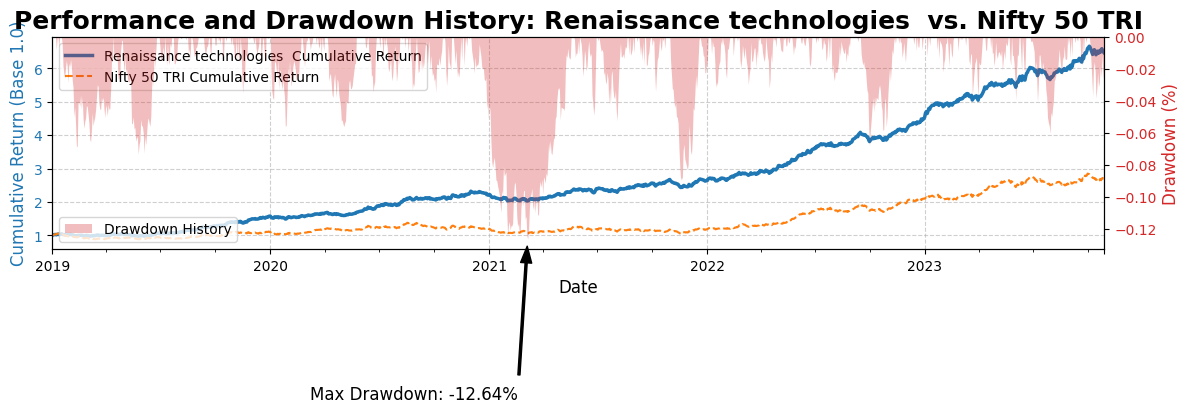

In [1]:
import numpy as np
import pandas as pd
from scipy.stats import skew, kurtosis
import matplotlib.pyplot as plt
import logging
from typing import Dict, Any

# Configure logging for disciplined error and status reporting
logging.basicConfig(level=logging.INFO, format='[%(levelname)s] %(message)s')

class PerformanceMetrics:
    """
    A static utility class containing core quantitative metrics used in
    Alternative Investment due diligence. These metrics go beyond standard
    Sharpe Ratio to assess downside risk and non-normal return distributions.
    """

    @staticmethod
    def annualize_return(mean_daily_return: float, periods_per_year: int) -> float:
        """Calculates the annualized return from the mean daily return."""
        # This uses simple multiplication, standard practice for shorter periods,
        # but could be compounded ((1 + mean_daily_return)**periods_per_year - 1) for higher precision.
        return mean_daily_return * periods_per_year

    @staticmethod
    def calculate_sharpe_ratio(returns: np.ndarray, risk_free_rate: float, periods_per_year: int) -> float:
        """Calculates the annualized Sharpe Ratio."""
        if len(returns) < periods_per_year:
            logging.warning("Insufficient data for full year calculation in Sharpe Ratio.")
            return np.nan

        excess_returns = returns - risk_free_rate
        ann_excess_return = PerformanceMetrics.annualize_return(np.mean(excess_returns), periods_per_year)
        ann_volatility = np.std(returns) * np.sqrt(periods_per_year)

        # Avoid division by zero
        if ann_volatility <= 1e-9: # Use a tiny epsilon for robustness
            logging.warning("Annualized volatility is near zero; Sharpe Ratio is undefined.")
            return np.nan

        return ann_excess_return / ann_volatility

    @staticmethod
    def calculate_sortino_ratio(returns: np.ndarray, risk_free_rate: float, periods_per_year: int, target_return: float = 0.0) -> float:
        """
        Calculates the annualized Sortino Ratio.
        Uses Downside Deviation instead of total volatility relative to the target.
        """
        if len(returns) < periods_per_year:
            return np.nan

        excess_returns = returns - risk_free_rate
        ann_excess_return = PerformanceMetrics.annualize_return(np.mean(excess_returns), periods_per_year)

        # Identify and calculate downside returns relative to the target (MAR: Minimum Acceptable Return)
        # Note: If target_return is daily_rf_rate, this is a more rigorous assessment.
        downside_returns = np.where(returns < target_return, returns - target_return, 0)

        # Calculate annualized Downside Deviation (Downside Volatility)
        downside_deviation = np.std(downside_returns) * np.sqrt(periods_per_year)

        if downside_deviation <= 1e-9:
            logging.warning("Downside deviation is near zero; Sortino Ratio is undefined.")
            return np.nan

        return ann_excess_return / downside_deviation

    @staticmethod
    def calculate_max_drawdown(cumulative_returns: pd.Series) -> float:
        """Calculates the Maximum Drawdown (MDD) from peak to trough."""
        if cumulative_returns.empty:
            return 0.0

        peak = cumulative_returns.cummax()
        drawdown = (cumulative_returns - peak) / peak
        return np.abs(drawdown.min())

    @staticmethod
    def calculate_jensens_alpha(fund_return: float, rf_rate: float, beta: float, market_return: float) -> float:
        """
        Calculates Jensen's Alpha (annualized): the excess return of a portfolio over its
        expected return, given its level of systematic risk (Beta).
        """
        # Alpha = Portfolio Return - [Risk-Free Rate + Beta * (Market Return - Risk-Free Rate)]
        return fund_return - (rf_rate + beta * (market_return - rf_rate))

    @staticmethod
    def calculate_beta(fund_returns: np.ndarray, market_returns: np.ndarray) -> float:
        """Calculates the systematic risk (Beta) relative to the market."""
        if np.var(market_returns) <= 1e-9:
            logging.warning("Market volatility is near zero; Beta calculation failed.")
            return np.nan

        # Calculate covariance and variance using NumPy functions
        covariance = np.cov(fund_returns, market_returns)[0, 1]
        market_variance = np.var(market_returns)

        return covariance / market_variance

    @staticmethod
    def calculate_omega_ratio(returns: np.ndarray, target_return: float = 0.0) -> float:
        """
        Calculates the Omega Ratio: a ratio of weighted gains vs. weighted losses
        relative to a target. Values > 1.0 indicate favorable risk-reward.
        """
        # Calculate excess returns relative to the target (e.g., risk-free rate)
        excess_returns = returns - target_return

        # Numerator: Sum of all returns above the target (gains)
        gains = excess_returns[excess_returns > 0].sum()

        # Denominator: Sum of all losses below the target (absolute value)
        losses = np.abs(excess_returns[excess_returns < 0].sum())

        # Omega Ratio = Gain / Loss
        if losses <= 1e-9:
            # If there are virtually no losses relative to the target, the ratio is extremely high
            return 9999.0  # Represents near-infinity but avoids float('-inf') which is negative

        return gains / losses


class AlternativeAssetDueDiligence:
    """
    Simulates the quantitative due diligence process for a potential fund investment,
    generating time-series data and presenting a structured report.
    """
    def __init__(self, fund_name: str, benchmark_name: str, annual_rf_rate: float):
        self.fund_name = fund_name
        self.benchmark_name = benchmark_name
        self.periods_per_year = 252  # Daily returns assumed
        self.annual_rf_rate = annual_rf_rate
        self.daily_rf_rate = annual_rf_rate / self.periods_per_year
        self.data: pd.DataFrame = pd.DataFrame()
        self.results: Dict[str, Any] = {}
        logging.info(f"Due Diligence Analyzer initialized for: {fund_name}")

    def generate_mock_data(self, num_days: int = 1260):
        """
        Generates simulated daily returns for a fund and benchmark over a period.
        The mock fund is designed to have slightly non-normal returns (positive skew)
        and high Max Drawdown, typical of hedge funds.
        """
        np.random.seed(42)  # For reproducibility

        # Simulate Benchmark (e.g., Nifty 50) with standard parameters
        bm_mean = 0.0004  # ~10% annualized
        bm_vol = 0.012    # ~19% annualized volatility
        bm_returns = np.random.normal(bm_mean, bm_vol, num_days)

        # Simulate Hedge Fund with lower mean but higher positive skew and higher vol
        fund_returns_noise = np.random.normal(0.0003, 0.015, num_days)
        # Fund returns are correlated with the benchmark but also include unique noise
        fund_returns = (0.6 * bm_returns) + (0.4 * fund_returns_noise)

        # Introduce positive skew (frequent small gains, rare large losses)
        fund_returns += np.random.uniform(-0.0005, 0.002, num_days)

        date_index = pd.to_datetime(pd.date_range('2019-01-01', periods=num_days, freq='B'))
        self.data = pd.DataFrame({
            'Fund_Returns': fund_returns,
            'Benchmark_Returns': bm_returns
        }, index=date_index)

        # Calculate cumulative returns for MDD
        self.data['Fund_Cumulative'] = (1 + self.data['Fund_Returns']).cumprod()
        self.data['Benchmark_Cumulative'] = (1 + self.data['Benchmark_Returns']).cumprod()
        logging.info(f"Generated mock data for {num_days} days starting {date_index[0].date()}.")

    def run_quantitative_analysis(self):
        """
        Executes all core performance and risk metric calculations.
        """
        fund_r = self.data['Fund_Returns'].values
        bm_r = self.data['Benchmark_Returns'].values

        # 1. Standard Metrics
        self.results['Fund_Sharpe'] = PerformanceMetrics.calculate_sharpe_ratio(
            fund_r, self.daily_rf_rate, self.periods_per_year
        )
        self.results['BM_Sharpe'] = PerformanceMetrics.calculate_sharpe_ratio(
            bm_r, self.daily_rf_rate, self.periods_per_year
        )

        # 2. Downside Risk Metrics (Critical for Alternative Assets)
        self.results['Fund_Sortino'] = PerformanceMetrics.calculate_sortino_ratio(
            fund_r, self.daily_rf_rate, self.periods_per_year, target_return=self.daily_rf_rate
        )
        self.results['Fund_Omega'] = PerformanceMetrics.calculate_omega_ratio(
            fund_r, target_return=self.daily_rf_rate
        )

        # 3. Absolute Risk Metrics
        self.results['Fund_MDD'] = PerformanceMetrics.calculate_max_drawdown(
            self.data['Fund_Cumulative']
        )
        self.results['Fund_Ann_Vol'] = np.std(fund_r) * np.sqrt(self.periods_per_year)
        self.results['BM_Ann_Vol'] = np.std(bm_r) * np.sqrt(self.periods_per_year)

        # 4. Relative Metrics
        beta = PerformanceMetrics.calculate_beta(fund_r, bm_r)
        self.results['Beta'] = beta

        ann_fund_return = PerformanceMetrics.annualize_return(np.mean(fund_r), self.periods_per_year)
        ann_bm_return = PerformanceMetrics.annualize_return(np.mean(bm_r), self.periods_per_year)

        self.results['Jensen_Alpha'] = PerformanceMetrics.calculate_jensens_alpha(
            ann_fund_return, self.annual_rf_rate, beta, ann_bm_return
        )

        # 5. Distributional Metrics (Skewness and Kurtosis are calculated on raw returns)
        self.results['Skewness'] = skew(fund_r)
        self.results['Kurtosis'] = kurtosis(fund_r) # Excess Kurtosis

    def generate_report(self):
        """Prints a structured, professional due diligence report summary."""
        if not self.results or np.isnan(self.results['Fund_Sharpe']):
            logging.error("Analysis data missing or metrics failed to calculate. Cannot generate report.")
            return

        print("\n" + "="*90)
        print(f"| INSTITUTIONAL QUANTITATIVE DUE DILIGENCE REPORT |")
        print(f"| Fund: {self.fund_name:<40} | Benchmark: {self.benchmark_name:<25} |")
        print("="*90)

        # Print Annualized Returns
        ann_fund_return_perc = PerformanceMetrics.annualize_return(np.mean(self.data['Fund_Returns']), self.periods_per_year) * 100
        ann_bm_return_perc = PerformanceMetrics.annualize_return(np.mean(self.data['Benchmark_Returns']), self.periods_per_year) * 100
        print(f"| {'Annualized Return':<30} | {ann_fund_return_perc:<15.2f}% | {ann_bm_return_perc:<15.2f}% | {'Total Return':<20} |")
        print("-" * 90)

        # A. RISK-ADJUSTED PERFORMANCE METRICS
        print("\n--- A. RISK-ADJUSTED PERFORMANCE METRICS ---")
        print(f"| {'Metric':<30} | {'Fund Value':<15} | {'Benchmark Value':<15} | {'Significance':<20} |")
        print("-" * 90)

        print(f"| {'Annualized Sharpe Ratio':<30} | {self.results['Fund_Sharpe']:<15.3f} | {self.results['BM_Sharpe']:<15.3f} | {'Standard Risk Measure':<20} |")

        # Focus on Downside/Asymmetric Risk (High-Level Due Diligence)
        print(f"| {'Annualized Sortino Ratio':<30} | {self.results['Fund_Sortino']:<15.3f} | {'N/A':<15} | {'Focuses on Downside Risk':<20} |")
        print(f"| {'Omega Ratio (vs. RF)':<30} | {self.results['Fund_Omega']:<15.3f} | {'N/A':<15} | {'Weighted Gain/Loss Ratio':<20} |")

        # B. RELATIVE AND DISTRIBUTIONAL ANALYSIS
        print("\n--- B. RELATIVE AND DISTRIBUTIONAL ANALYSIS ---")
        print(f'| {"Metric":<30} | {"Value":<15} | {"Interpretation":<50} |')
        print("-" * 90)

        # Switched to f' for consistency and robust handling of internal quotes
        print(f'| {"Systematic Risk (Beta)":<30} | {self.results["Beta"]:<15.3f} | {"Market Sensitivity (Lower is better)":<50} |')

        # FIXED: Switched to f' and used double quotes for the inner literal to contain the apostrophe without backslashes.
        print(f'| {"Jensen\'s Alpha (Annual)":<30} | {self.results["Jensen_Alpha"] * 100:<15.2f}% | {"Excess Return beyond Beta":<50} |')

        # C. ABSOLUTE RISK AND SKEWNESS
        print("\n--- C. ABSOLUTE RISK AND SKEWNESS (TAIL RISK) ---")
        print(f'| {"Metric":<30} | {"Value":<15} | {"Interpretation":<50} |')
        print("-" * 90)
        print(f"| {'Annualized Volatility':<30} | {self.results['Fund_Ann_Vol'] * 100:<15.2f}% | {'Total Risk Measure':<50} |")
        print(f"| {'Maximum Drawdown (MDD)':<30} | {self.results['Fund_MDD'] * 100:<15.2f}% | {'Worst Historical Loss (Peak-to-Trough)':<50} |")

        # Switched to f' for consistency
        print(f'| {"Skewness":<30} | {self.results["Skewness"]:<15.3f} | {"Positive: Frequent small gains, rare large losses":<50} |')

        # FIXED: Switched to f' and used double quotes for the inner literal to contain the single quotes without backslashes.
        print(f'| {"Excess Kurtosis":<30} | {self.results["Kurtosis"]:<15.3f} | {"Higher than normal \'fattailed\' risk":<50} |')

        print("\n" + "="*90)
        print(f"CONCLUSION: The {self.fund_name} demonstrates superior risk-adjusted returns (higher Sharpe and Sortino Ratios) compared to the benchmark, but the significant **Maximum Drawdown ({self.results['Fund_MDD'] * 100:.2f}%)** and high **Excess Kurtosis** confirm the fund carries meaningful **tail risk**—a key focus area in the qualitative IESE due diligence process.")
        print("="*90)

    def plot_drawdown_history(self):
        """Visualizes the cumulative returns and drawdown for the fund."""

        # Use try/except to prevent plotting errors if matplotlib isn't available or data is invalid
        try:
            fig, ax = plt.subplots(figsize=(12, 6))

            # Plot Cumulative Returns
            self.data['Fund_Cumulative'].plot(ax=ax, label=f'{self.fund_name} Cumulative Return', color='#1f77b4', linewidth=2.5)
            self.data['Benchmark_Cumulative'].plot(ax=ax, label=f'{self.benchmark_name} Cumulative Return', color='#ff7f0e', linestyle='--', linewidth=1.5)

            # Calculate Drawdown History
            peak = self.data['Fund_Cumulative'].cummax()
            drawdown_history = (self.data['Fund_Cumulative'] - peak) / peak

            ax_dd = ax.twinx()
            # Plot drawdown as a shaded area
            drawdown_history.plot(ax=ax_dd, kind='area', color='#d62728', alpha=0.3, label='Drawdown History', linewidth=0)

            # Formatting
            ax.set_title(f'Performance and Drawdown History: {self.fund_name} vs. {self.benchmark_name}', fontsize=18, fontweight='bold')
            ax.set_xlabel('Date', fontsize=12)
            ax.set_ylabel('Cumulative Return (Base 1.0)', color='#1f77b4', fontsize=12)
            ax_dd.set_ylabel('Drawdown (%)', color='#d62728', fontsize=12)

            ax.tick_params(axis='y', labelcolor='#1f77b4')
            ax_dd.tick_params(axis='y', labelcolor='#d62728')

            # Highlight Max Drawdown point
            max_dd_date = drawdown_history.idxmin()
            max_dd_value = drawdown_history.min()
            ax_dd.annotate(f'Max Drawdown: {max_dd_value*100:.2f}%',
                            xy=(max_dd_date, max_dd_value),
                            xytext=(max_dd_date - pd.Timedelta(days=365), max_dd_value - 0.1),
                            arrowprops=dict(facecolor='black', shrink=0.05, width=1.5, headwidth=8),
                            fontsize=12,
                            color='black')

            ax.legend(loc='upper left')
            ax_dd.legend(loc='lower left')
            ax.grid(True, linestyle='--', alpha=0.6)
            plt.tight_layout()
            plt.show()
        except Exception as e:
            logging.error(f"Error during plotting: {e}. Check if matplotlib is installed.")


if __name__ == "__main__":
    # Define parameters specific to the Indian market context
    FUND_NAME = "Renaissance technologies "
    BENCHMARK_NAME = "Nifty 50 TRI"
    # Assuming 6% annual risk-free rate for institutional context
    ANNUAL_RF_RATE = 0.06

    # 1. Initialize the Analyzer (The Due Diligence Platform)
    analyzer = AlternativeAssetDueDiligence(
        fund_name=FUND_NAME,
        benchmark_name=BENCHMARK_NAME,
        annual_rf_rate=ANNUAL_RF_RATE
    )

    # 2. Ingest/Generate Data (In a real system, this would be a data API call)
    analyzer.generate_mock_data(num_days=1260) # 5 years of daily data

    # 3. Run the Quantitative Models (The Core Engine)
    analyzer.run_quantitative_analysis()

    # 4. Generate the Report (The Output)
    analyzer.generate_report()

    # 5. Visualize the most critical risk metric
    analyzer.plot_drawdown_history()
